In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
from torchview import draw_graph
from torchviz import make_dot

from moduleZoo.graphs import GraphConv

In [2]:
class TargetModel(nn.Module):
    def __init__(self, db = False) -> None:
        super().__init__()
        self.module = GraphConv(128, 256, k=10, dynamic_batching=db, enable_offloading=True)

    def enable_dynamic_batching(self) -> None:
        self.module.db = True

    def forward(self, x:torch.Tensor, n_nodes = None) -> torch.Tensor:
        n_nodes = (np.ones((10, ), dtype=np.int16)*100).tolist() + (np.ones((10, ), dtype=np.int16)*50).tolist()*2
        x = x.view((2*10*100, 128))
        return self.module(x, n_nodes)

In [3]:
module = TargetModel(True)

In [4]:
# model_graph = draw_graph(module, input_size=(10*100, 128), expand_nested=False)
summary(module, (10*100, 128))

Using static dynamic batching.
Layer (type:depth-idx)                   Output Shape              Param #
├─GraphConv: 1-1                         [-1, 256]                 --
|    └─Linear: 2-1                       [-1, 50, 10, 256]         65,792
|    └─Linear: 2-2                       [-1, 100, 10, 256]        (recursive)
Total params: 65,792
Trainable params: 65,792
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.49
Forward/backward pass size (MB): 0.98
Params size (MB): 0.25
Estimated Total Size (MB): 1.72


Layer (type:depth-idx)                   Output Shape              Param #
├─GraphConv: 1-1                         [-1, 256]                 --
|    └─Linear: 2-1                       [-1, 50, 10, 256]         65,792
|    └─Linear: 2-2                       [-1, 100, 10, 256]        (recursive)
Total params: 65,792
Trainable params: 65,792
Non-trainable params: 0
Total mult-adds (M): 0.20
Input size (MB): 0.49
Forward/backward pass size (MB): 0.98
Params size (MB): 0.25
Estimated Total Size (MB): 1.72

In [5]:
# model_graph.visual_graph.save(filename='graph-conv.svg')

In [6]:
module = module.to('cuda')

In [7]:
data = torch.rand((10, 100, 128), device='cuda')
print(f'{data.shape = }')
# n_nodes = [1]*(256//2) + [2]*(256//4)
# n_nodes = np.array(n_nodes*2)

data.shape = torch.Size([10, 100, 128])


In [8]:
result1 = module(data)

Using static forward


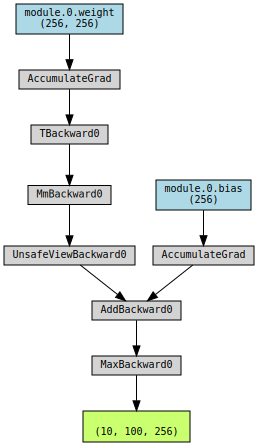

In [9]:
make_dot(result1, params=dict(module.named_parameters()))

In [10]:
module.module.db = True

In [11]:
data = data.view((10*100, 128))
n_nodes = np.ones((10, ), dtype=np.int16)*100

In [12]:
result2 = module(data, n_nodes).view((10, 100, 256))

Using static dynamic batching.


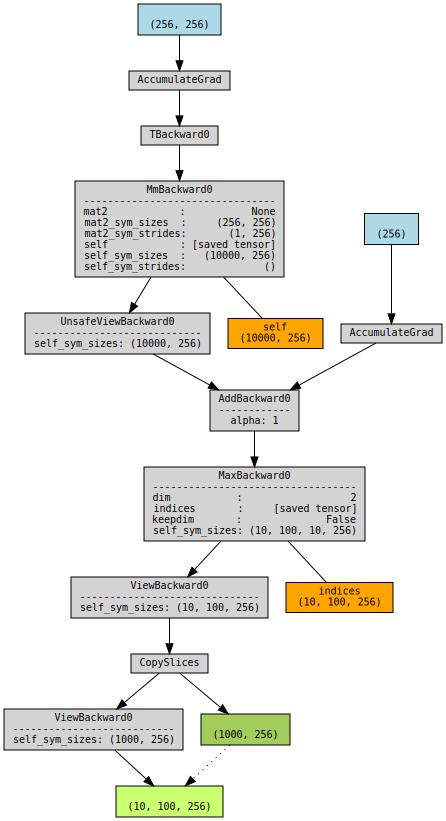

In [15]:
make_dot(result2, show_attrs=True, show_saved=True)

In [16]:
module.module.db = False

In [17]:
result3 = module(data, n_nodes).view((10, 100, 256))

Using complete dynamic batching


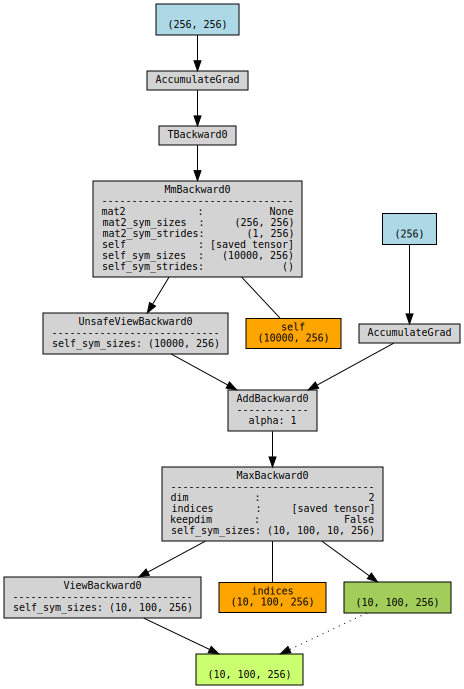

In [18]:
make_dot(result3, show_attrs=True, show_saved=True)

In [14]:
torch.all(result3 == result2) and torch.all(result1 == result2)

tensor(True, device='cuda:0')

In [13]:
torch.all(torch.cat(data.view((10, 100, 128)).split(1, dim=0), dim=1).squeeze(dim=0) == data)

tensor(True, device='cuda:0')